# M1N Folkersma, pt 2

Workflow to create a network from Folkersma data.
* Part 1 (Python): from raw data to QGIS input
* Part 2 (QGIS): from QGIS input to nx input
* **Part 3 (Python): from nx input to graph object**

## Step 3

In [1]:
# Load libraries
import os
import pandas as pd
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import shapely
from shapely.geometry import Point, LineString, MultiLineString
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
import momepy
import numpy as np
import math
import contextily as cx

**1. Import file genereated by QGIS workflow in Step 2**
(cf. previous notebook)

In [2]:
gdf = gpd.read_file("../qgis/folkersma/filtered_snapB6T5.gpkg")
gdf = gdf.explode(index_parts = False)
gdf.head(3)

,rating,geometry
0,1.0,"LINESTRING (675365.070 6123560.480, 675365.580..."
1,1.0,"LINESTRING (674260.732 6124551.179, 674266.410..."
2,1.0,"LINESTRING (675150.640 6123856.800, 675154.050..."


**Process and check components**

comps: 4
degrees: [0, 118, 260, 1063, 136, 7, 1]


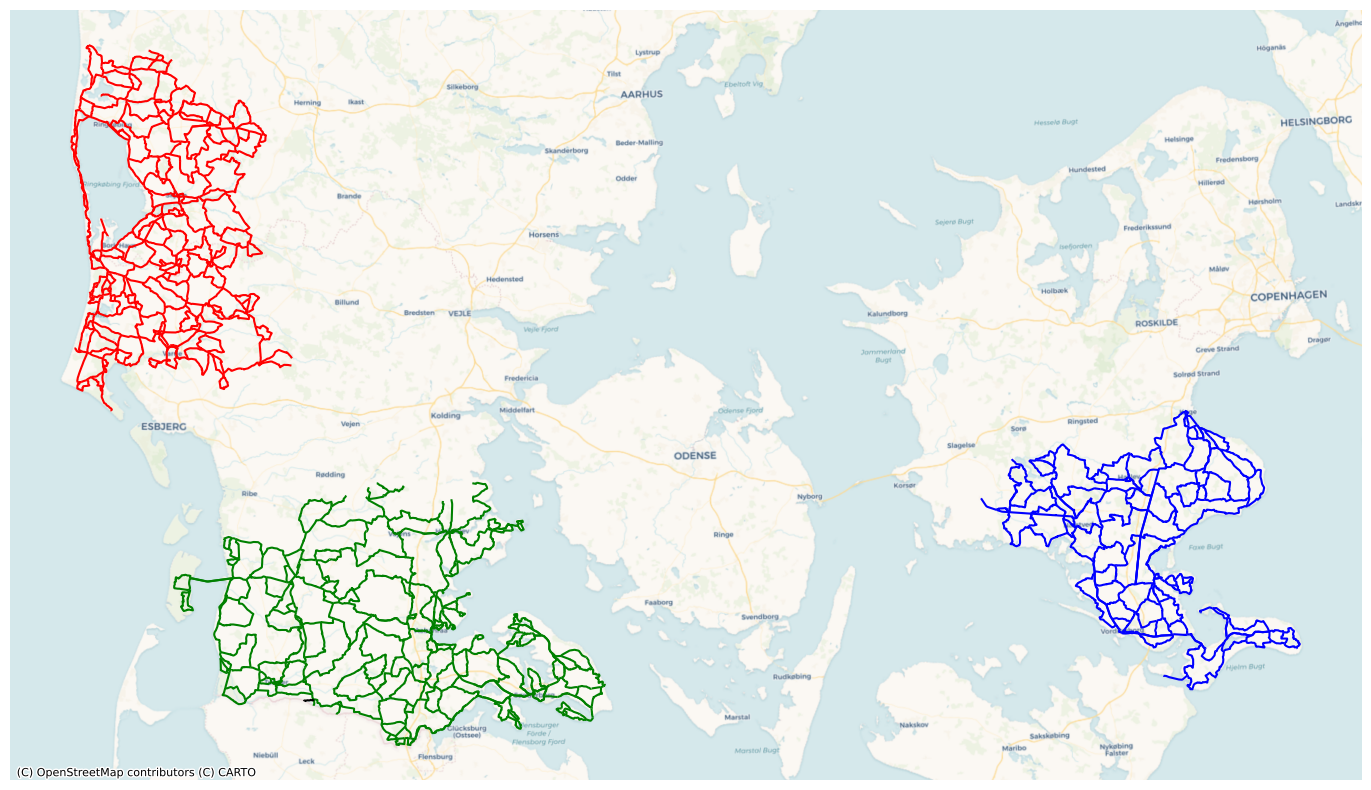

In [3]:
# get "noded" gdf
n = shapely.node(gdf.unary_union)
n = gpd.GeoDataFrame({"geometry": [n]}, crs = "EPSG:25832")
n = n.explode(index_parts=False).reset_index(drop=True)
n["id"] = n.index

# make graph 
Gdir = momepy.gdf_to_nx(n)
G = Gdir.to_undirected()
print("comps:", len([c for c in nx.connected_components(G)]))
print("degrees:", nx.degree_histogram(G))

# plot components
geomdict = nx.get_edge_attributes(G, "geometry")

edges = gpd.GeoDataFrame(
    {
        "geometry": geomdict.values(), 
        "id" : geomdict.keys()
    },
    crs = "EPSG:25832"
)

edges["degrees"] = edges.apply(
    lambda x: 
        int(str(sorted([G.degree(x.id[0]), G.degree(x.id[1])])).replace("[", "").replace(", ", "").replace("]","")),
    axis = 1)

nodes = gpd.GeoDataFrame(
    {
        "geometry": [Point(node) for node in G.nodes],
        "id": list(G.nodes)
    },
    crs = "EPSG:25832"
)

nodes["degree"] = nodes.apply(lambda x: G.degree(x.id), axis = 1)

# edges[["geometry", "degrees"]].to_file("../qgis/folkersma/tempedges.gpkg", index = False)
# nodes[["geometry","degree"]].to_file("../qgis/folkersma/tempnodes.gpkg", index = False)

mycols = ["blue", "red", "green", "black", "black", "black"]

fig, ax = plt.subplots(1, 1, figsize = (20,10))

comps = [c for c in nx.connected_components(G)]

for j, comp in enumerate(comps):
    gpd.GeoDataFrame(
        geometry = list(nx.get_edge_attributes(
            nx.subgraph(G, comp), "geometry").values())).plot(
                ax = ax, color = mycols[j])
cx.add_basemap(ax = ax, crs="EPSG:25832", source=cx.providers.CartoDB.Voyager)
ax.set_axis_off()

**Save 3 LCCs as separate graphs**

In [4]:
G_stevns = nx.subgraph(G, comps[0]).copy()
G_aabenraa = nx.subgraph(G, comps[1]).copy()
G_skjern = nx.subgraph(G, comps[2]).copy()

***
***

**What to check (testing for Stevns)**

* segment length (lined up)
* node density
* segment straightness
* node loneliness

**Segment length**

In [5]:
del(G)
G = G_stevns.copy()

In [6]:
geomdict = nx.get_edge_attributes(G, "geometry")

segments = gpd.GeoDataFrame(
    {
    "geometry": geomdict.values(),
    "id" : geomdict.keys()
    },
    crs = G.graph["crs"]
)
segments["length_km"] = np.round(segments.geometry.length / 1000, 2)

<AxesSubplot: >

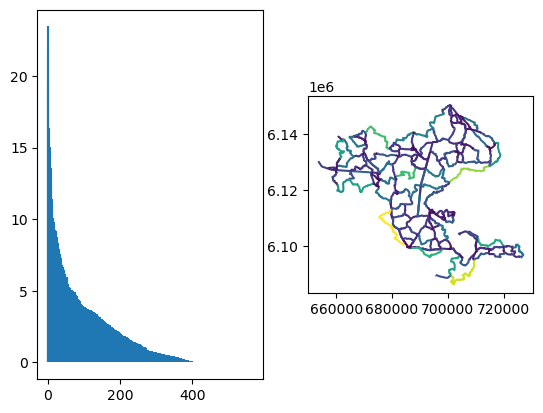

In [141]:
fig, ax = plt.subplots(1,2)

i = 0
ax[i].vlines(
    x = [range(0,len(segments))],
    ymin = [0]*len(segments),
    ymax = sorted(list(segments.length_km), reverse = True),
)

i = 1
segments.plot(ax=ax[i], column="length_km", cmap = "viridis")


**Segment "straightness"**

In [88]:
def get_detourfactor(ls):
    actual_length = ls.length
    a = ls.coords[0]
    b = ls.coords[-1]
    total_length = LineString([a,b]).length
    if total_length > 0:
        return actual_length/total_length
    else:
        return 1

In [89]:
segments["crow"] = segments.apply(
    lambda x:
        get_detourfactor(x.geometry),
    axis = 1
)

<AxesSubplot: >

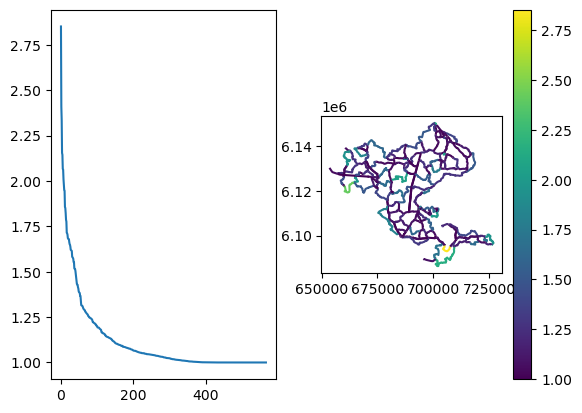

In [98]:
fig, ax = plt.subplots(1,2)

i = 0
ax[i].plot(
    sorted(list(segments.crow), reverse = True),
)

i = 1
segments.plot(ax=ax[i], column="crow", cmap = "viridis", legend = True)


<AxesSubplot: >

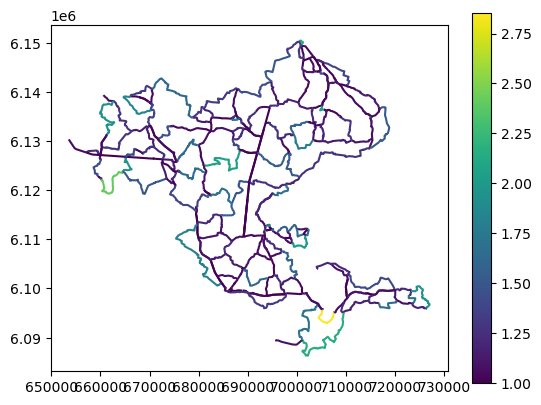

In [99]:
segments.plot(column="crow", cmap = "viridis", legend = True)


In [11]:
# heights = sorted(
#     [l.length for l in list(
#         nx.get_edge_attributes(
#             nx.subgraph(G, comps[0]),
#             "geometry"
#         ).values())
#     ],
#     reverse = True)
# heights = [h for h in heights if h>20]
# heights = [h/10**3 for h in heights]

# fig, ax = plt.subplots(1,1)
# ax.bar(
#     x = [i for i in range(len(heights))],
#     height = heights)

**Node densities**

In [102]:
points = gpd.GeoDataFrame(
    {
        "geometry": [Point(node) for node in G.nodes],
        "id": list(G.nodes)
    },
    crs = "EPSG:25832"
)

points["degree"] = points.apply(lambda x: G.degree(x.id), axis = 1)

<AxesSubplot: >

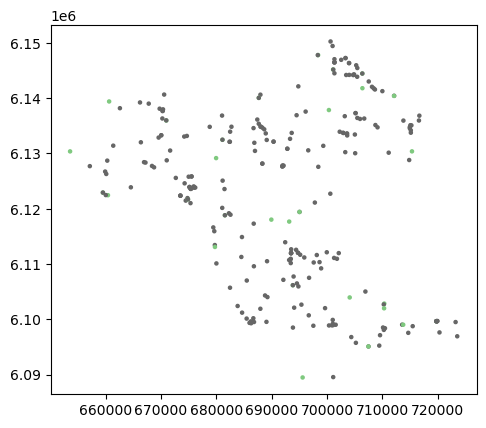

In [114]:
points[(points["degree"]==3) | (points["degree"]==1)].plot(
    column = "degree", 
    cmap = "Accent",
    markersize = 5)

<AxesSubplot: >

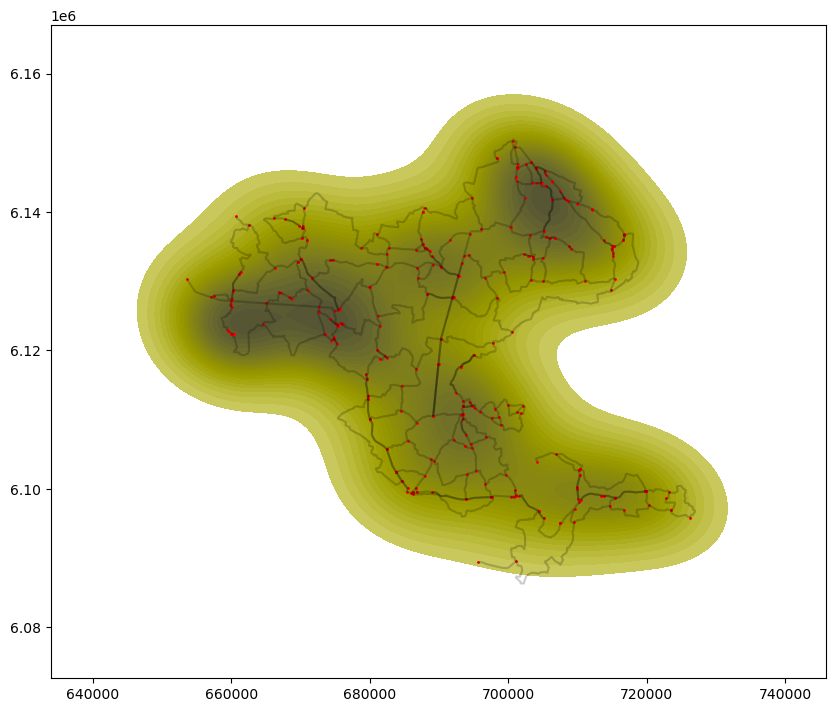

In [128]:
import seaborn as sns
from matplotlib.cm import get_cmap
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.kdeplot(ax=ax,
    x = [p.coords[0][0] for p in points["geometry"]],
    y = [p.coords[0][1] for p in points["geometry"]],
    fill = True,
    levels = 30,
    color = "yellow"
)

segments.plot(ax=ax, color = "black", alpha = 0.2)
points.plot(ax=ax, markersize = 1, color = "red")


**Lonely nodes?**

In [166]:
def find_lonelies(graph, node, threshold):
    neighbour_distances = np.array(
        [e[2]["geometry"].length/1000 for e in graph.edges(node, data = True)]
    )
    return(all(neighbour_distances>5))

points["lonely"] = points.apply(
    lambda x:
        find_lonelies(G, x.id, 5),
    axis = 1
)


<AxesSubplot: >

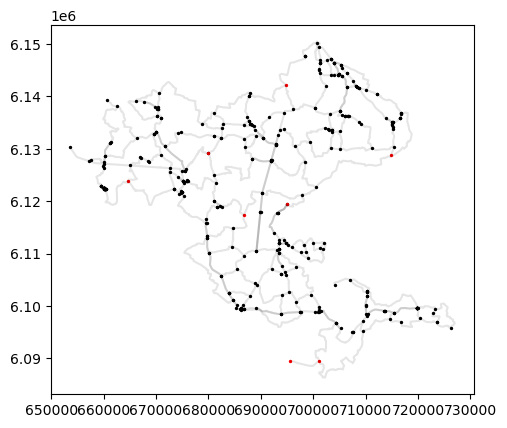

In [170]:
fig, ax = plt.subplots(1,1)
points[points["lonely"]==False].plot(ax=ax, color = "black", markersize = 2)
points[points["lonely"]==True].plot(ax=ax, color = "red", markersize = 2)
segments.plot(ax=ax, color = "black", alpha = 0.1)

**Edge betweenness**

In [173]:
nbc = nx.betweenness_centrality(G, weight = "mm_len")

In [182]:
ebc = nx.edge_betweenness_centrality(G, weight = "mm_len")

In [175]:
points["nbc"] = None
for k, v in nbc.items():
    points.loc[points["id"]==k, "nbc"] = v

In [186]:
segments["ebc"] = None
for k, v in ebc.items():
    segments.loc[segments["id"]==k, "ebc"] = v

/Users/anvy/opt/anaconda3/envs/OSMNX/lib/python3.9/site-packages/geopandas/plotting.py:807: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  cat = pd.Categorical(values, categories=categories)


<AxesSubplot: >

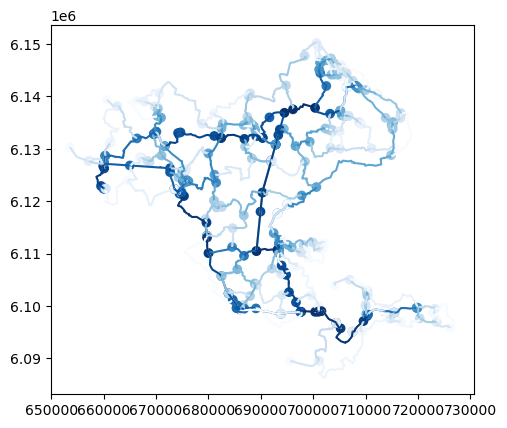

In [189]:
fig, ax = plt.subplots(1,1)
segments.plot(ax=ax, column = "ebc", cmap = "Blues")
points.plot(ax=ax, column = "nbc", cmap = "Blues")